In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [2]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")
sub_sample = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

print (train.shape, test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


## Limpieza de la Columna Text

- Se elimina enlaces y espacios en blanco innecesarios
- Se crea columnas separadas que contengan listas de hashtags, menciones y enlaces.

In [3]:
import re

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Se elimina link
    text = re.sub(r'\n',' ', text) # Se elimina saltos de linea
    text = re.sub('\s+', ' ', text).strip() # Se eliminan espacios iniciales, finales y adicionales
    return text

def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))    
    return df

train = process_text(train)
test = process_text(test)

### Se crean estadisticas a partir de la Columna text

In [4]:
from wordcloud import STOPWORDS

def crear_estadistica(df):
    # Longitud del Tweet
    df['text_len'] = df['text_clean'].apply(len)
    # Cantidad de Palabras
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Cantidad de Stopword
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Cantidad de Puntuaciones (.)
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Cantidad de Hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Cantidad de Menciones (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Cantidad de Links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Cantidad de letras Mayusculas
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Proporcion de letras Mayusculas
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = crear_estadistica(train)
test = crear_estadistica(test)

print(train.shape, test.shape)

(7613, 18) (3263, 17)


## Limpieza de la Columna Location

- Se une las localizaciones equivalentes
- Dejamos las localizaciones que estan en el Top 10 y es resto lo agrupamos en Others

In [5]:
# Fill NA values
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)

for col in ['keyword','location']:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train['location_clean'] = train['location'].apply(lambda x: clean_loc(str(x)))
test['location_clean'] = test['location'].apply(lambda x: clean_loc(str(x)))

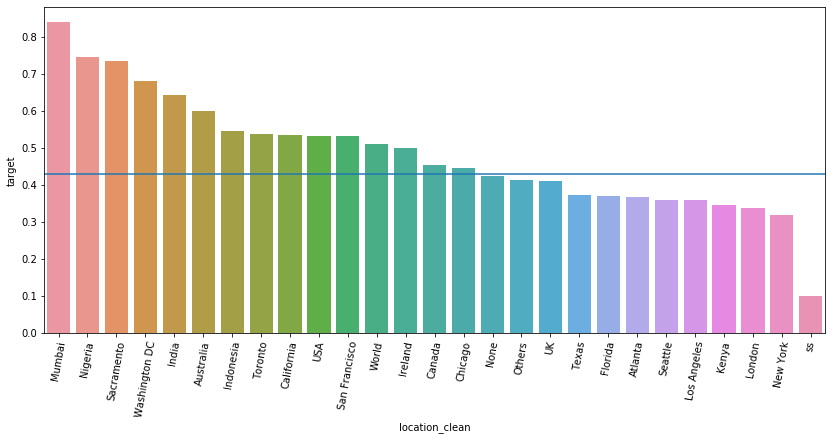

In [6]:
top_l2 = train.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

## Codificacion de variables categoricas

Como parte de la generacion de feactures haremos lo siguiente
- Aplicar target encoding para las columnas keyword y location

In [7]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location_clean']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features],train['target'])

train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

## Bag of Words

- Se aplica countVectorizer el cual genera una columna por palabra y cuenta la frecuencia de cada palabra
- Se aplica Bag of Words a las columnas Links, Mentions, Hashtags 

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


- Se aplica TF-IDF a la columna Text

In [9]:
# Tf-idf for text
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train['text_clean'])
text_vec_test = vec_text.transform(test['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1691)


In [10]:
# Joining the dataframes together

train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1843) (3263, 1842)


## Random Forest

Como parte del preprocesamiento se escalan los datos aplicando normalizacion y como modelo Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor


features_to_drop = ['id', 'keyword','location','text','location_clean','text_clean', 'hashtags', 'mentions','links']

X_train = train.drop(columns = features_to_drop + ['target'])
X_test = test.drop(columns = features_to_drop)
y_train = train.target

rf_model = RandomForestRegressor(max_depth=200, n_estimators=400, min_samples_split=20, min_samples_leaf=1,
                           max_features=15)
rf_model.fit(X_train, y_train)

y_test = rf_model.predict(X_test)

submit = sub_sample.copy()
submit.target = y_test
submit.to_csv('submit_random_forest.csv',index=False)

In [13]:
# F-1 score
from sklearn.metrics import f1_score

print ("Training set f1_score :", np.round(f1_score(y_train, y_test),5))

ValueError: Found input variables with inconsistent numbers of samples: [7613, 3263]

In [15]:
# Matriz de Confucion
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, rf_model.predict(X_train)))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

## Evaluacion del Modelo

In [16]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score))

ValueError: Classification metrics can't handle a mix of binary and continuous targets